In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

np.random.seed(42)
tf.set_random_seed(42)

/Users/mwoods/Developer/open-ai-gym/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
env = gym.make('CartPole-v0')
path_to_recording = './tmp/CartPole-v0-gradient'

[2017-02-06 23:44:15,558] Making new env: CartPole-v0


In [3]:
GAMMA = 0.97
def DQN():
    """
    4 layer(2 hidden layer) network
    input: state array
    output: estimated q_values(future reward for choosing that action)
    """

    state = tf.placeholder(dtype = tf.float32, shape = (None, 4))
    Q_actuals = tf.placeholder(dtype=tf.float32, shape = (None, 2))

    w1 = tf.Variable(tf.truncated_normal([4, 10], stddev = 0.1))
    b1 = tf.Variable(tf.truncated_normal([10], stddev = 0.1))
    h1 = tf.nn.relu(tf.matmul(state, w1) + b1)

    w2 = tf.Variable(tf.truncated_normal([10, 10], stddev=0.1))
    b2 = tf.Variable(tf.truncated_normal([10], stddev=0.1))
    h2 = tf.nn.relu(tf.matmul(h1, w2) + b2)

    w3 = tf.Variable(tf.random_normal([10, 2]))
    b3 = tf.Variable(tf.zeros([2]))
    Q_est = tf.matmul(h2, w3) + b3

    loss = tf.nn.l2_loss(Q_est - Q_actuals)
    optimizer = tf.train.AdamOptimizer().minimize(loss)
    return optimizer, state, Q_actuals, Q_est, loss, w1, w2, w3

dqn_opt, dqn_state, dqn_q_actuals, dqn_q_est, dqn_loss, w1, w2, w3 = DQN()


class ExperienceReplay:
    
    def __init__(self):
        self.memory = []
        self.max_size = 50000
        self.batch_size = 128
        self.gamma = GAMMA
        
    def add_observation(self, step, obs, action, reward, is_done, new_obs, future_reward):
        if len(self.memory) > self.max_size:
            self.memory.pop(0) #remove older samples    
        self.memory.append((step, obs, action, reward, is_done, new_obs, future_reward))
    
    def get_mini_batch(self):
        samples = np.random.choice(len(self.memory), self.batch_size)
        return [self.memory[idx] for idx in samples]
    
    def train(self,sess):
        batch = self.get_mini_batch()
        step_batch, obs_batch, action_batch, reward_batch, is_done_batch, \
        new_obs_batch, future_reward_batch = map(np.array, zip(*batch))
        
        #get next q values by running DQN on Next States
        #calculate max next q
        #update current state with (reward  + max next q - old q)  
        
        q_vals = sess.run(dqn_q_est, feed_dict = {dqn_state : obs_batch})        
        new_obs_q_vals = sess.run(dqn_q_est, feed_dict = {dqn_state : new_obs_batch})
        maxQ = np.max(new_obs_q_vals, axis = 1)
        
        target_q_vals = q_vals[:]
        target_q_vals[np.arange(self.batch_size), action_batch] = future_reward_batch \
                                                                + ((1.0 - is_done_batch.astype(int)))*self.gamma*maxQ
        
        l, _ = sess.run([dqn_loss, dqn_opt], feed_dict={dqn_state : obs_batch, 
                                                        dqn_q_actuals: target_q_vals
                                                       })
        return l
        
        

In [4]:

MemoryReplay = ExperienceReplay()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

TOTAL_NUMBER_OF_TRAINING_EPISODES = 0
train_loss_hist = []
reward_hist = []
steps_hist = []
max_prob_eps_mean = []
max_prob_eps_std = []
mean_advantage = []


In [5]:
num_episodes = 7501
report_interval = 100
stopping_steps = 1000

softmax = lambda np_arr : np.exp(np_arr)/np.sum(np.exp(np_arr))

for episode in range(num_episodes):
    obs = env.reset()
    total_reward = 0.0
    total_steps = 0.0
    episode_history = []
    states = []
    max_prob = []
    while True:
        
        q_est = sess.run(dqn_q_est, feed_dict={dqn_state: np.expand_dims(obs, axis=0)})
        q_est = q_est[0] #unpack the values

        #need to define a better exploration_function
        q_est_softmax = softmax(q_est)
        max_prob.append(q_est_softmax.max())
        action = np.random.choice([0, 1], p = q_est_softmax)
        #print action, q_est_softmax
        next_obs, reward, is_done, _ = env.step(action)
        
        unk_future_reward = None
        episode_history.append([total_steps, obs, action, reward, is_done, next_obs, unk_future_reward]) 
        total_reward += reward
        total_steps += 1.0
        obs = next_obs
        if is_done or total_steps > stopping_steps * 2:
            break
    #print total_steps
    future_rewards = []
    cumm_reward = 0.0
    for idx, trans in enumerate(episode_history[::-1]): 
        _, obs, action, reward, is_done, next_obs, future_reward = trans
        cumm_reward += (GAMMA**idx) * reward
        future_rewards.append(cumm_reward)
    future_rewards = np.array(future_rewards[::-1]) #go through the array in reverse and then flip it back at then end
    fr_mu, fr_sigma = future_rewards.mean(), future_rewards.std()
    future_rewards = (future_rewards - fr_mu)/fr_sigma
    
    for trans, future_reward in zip(episode_history, future_rewards):
        trans[-1] = future_reward
        #print trans[0], trans[2], trans[3], trans[4], trans[-1]
        MemoryReplay.add_observation(*trans)
    
    
    train_loss = MemoryReplay.train(sess)
    
    #load monitoring dbs
    max_prob_eps_mean.append(np.array(max_prob).mean())
    max_prob_eps_std.append(np.array(max_prob).std())
    reward_hist.append( total_reward )
    steps_hist.append( total_steps )
    train_loss_hist.append(train_loss)
    TOTAL_NUMBER_OF_TRAINING_EPISODES += 1
    
    if episode % report_interval == 0:
        tot =  TOTAL_NUMBER_OF_TRAINING_EPISODES
        avg_steps = np.mean(steps_hist[-report_interval:])
        avg_loss = np.mean(train_loss_hist[-report_interval:])
        print 'total_num_training', tot , 'epsiode', episode, 'steps', avg_steps, 'loss', avg_loss
        
    #stop
    if avg_steps > stopping_steps:
        print 'max performance with avg steps', avg_steps 
        break
    


total_num_training 1 epsiode 0 steps 19.0 loss 75.3894
total_num_training 101 epsiode 100 steps 23.79 loss 63.9502
total_num_training 201 epsiode 200 steps 26.54 loss 58.9871
total_num_training 301 epsiode 300 steps 35.2 loss 59.9492
total_num_training 401 epsiode 400 steps 43.61 loss 69.8407
total_num_training 501 epsiode 500 steps 56.12 loss 78.9872
total_num_training 601 epsiode 600 steps 72.77 loss 80.3355
total_num_training 701 epsiode 700 steps 90.61 loss 93.4235
total_num_training 801 epsiode 800 steps 139.05 loss 122.546
total_num_training 901 epsiode 900 steps 167.77 loss 119.674
total_num_training 1001 epsiode 1000 steps 128.15 loss 131.053
total_num_training 1101 epsiode 1100 steps 79.36 loss 142.88
total_num_training 1201 epsiode 1200 steps 134.94 loss 110.036
total_num_training 1301 epsiode 1300 steps 282.87 loss 120.314
total_num_training 1401 epsiode 1400 steps 394.62 loss 107.693
total_num_training 1501 epsiode 1500 steps 200.97 loss 93.7959
total_num_training 1601 epsi

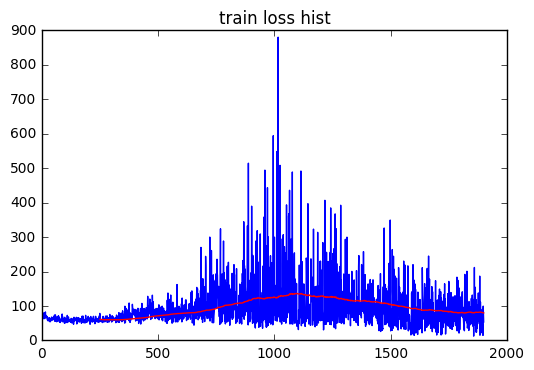

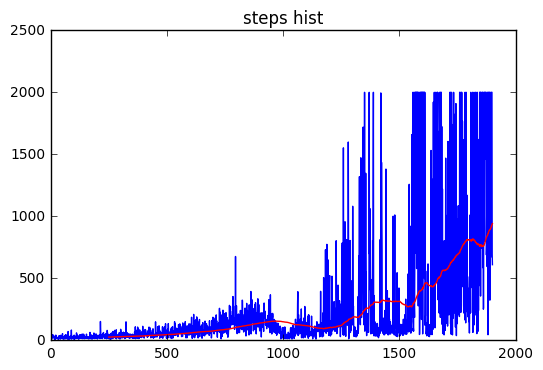

In [6]:
plt.title("train loss hist")
plt.plot(train_loss_hist)
plt.plot([None]*250 + [np.mean(train_loss_hist[i-250 : i]) for i in range(250, len(train_loss_hist))], c = "red")
plt.show()

plt.title("steps hist")
plt.plot(steps_hist)
plt.plot([None]*250 + [np.mean(steps_hist[i-250:i]) for i in range(250, len(steps_hist))], c = "red")
plt.show()

In [7]:
np.mean(range(20))

9.5